In [1]:
import scanpy as sc
import anndata
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from torch.nn.functional import softmax
from torch.nn import Softmax

# read h5ad and extract features & labels

In [66]:
adata_ref = sc.read_h5ad("data/sce_relabel.h5ad")

In [67]:
adata_query = sc.read_h5ad("data/sce_query.h5ad")

In [68]:
#adata_lcfl

In [69]:
adata_ref = adata_ref[adata_ref.obs["ethnicity_relabel"]!= "LowConfidenceLabel", :]

In [70]:
#features = adata_ref.obsm['PCA'].values

In [71]:
if hasattr(adata_ref.layers["counts_adjusted_ethnicity"], "toarray"):
    features = adata_ref.layers["counts_adjusted_ethnicity"].toarray()
else:
    features = adata_ref.layers["counts_adjusted_ethnicity"]

In [72]:
#df = pd.read_csv("./data/feature_label_ref.csv")

In [73]:
#features = df.filter(like='PC').values

In [74]:
#labels = df["ethnicity"].values

In [75]:
features.shape

(2764, 146)

In [76]:
features

array([[  40.68944366,    0.        , 1216.1278628 , ...,  426.76466588,
        1421.20271074,  112.12154843],
       [  15.70266997,   89.49157169, 3335.98492658, ...,  444.89964337,
        1803.26379291,   89.82846071],
       [  57.54489648,   77.95816338,  957.78446339, ...,  217.03454015,
        2452.44351091,  113.77857743],
       ...,
       [  40.92979516,   89.47075153, 1495.89161084, ...,  410.18246723,
        1149.75808244,  138.65502126],
       [  26.0452927 ,   82.95019942, 5657.36764061, ...,  784.02913058,
         866.16194695,   72.27868316],
       [  40.92979516,   89.47075153, 1495.89161084, ...,  410.18246723,
        1150.53928462,  138.65502126]])

In [77]:
labels = adata_ref.obs["ethnicity_relabel"].values

In [78]:
labels

['European', 'East Asian', 'European', 'Japanese', 'East Asian', ..., 'European', 'European', 'European', 'European', 'European']
Length: 2764
Categories (6, object): ['African', 'East Asian', 'European', 'Hispanic/Latin American', 'Japanese', 'South Asian']

# make labels into integers

In [79]:
ethnicity_to_idx = {
    'African': 0,
    'East Asian': 1,
    'European': 2,
    'Hispanic/Latin American': 3,
    'Japanese': 4,
    'South Asian': 5
}

In [80]:
labels_int = np.array([ethnicity_to_idx[label] for label in labels])

In [81]:
labels_int

array([2, 1, 2, ..., 2, 2, 2])

# split data

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels_int, test_size=0.2, stratify=labels_int, random_state=22)

In [83]:
pca = PCA(n_components=20)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# make pytorch

In [84]:
class RNADataset(Dataset):
    def __init__(self, features, labels=None, transform=None):
        self.features = features.astype(np.float32)
        self.labels = labels.astype(np.int64) if labels is not None else None
        self.transform = transform

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        x = self.features[idx]
        if self.transform:
            x = self.transform(x)
        if self.labels is not None:
            y = self.labels[idx]
            return x, y
        return x

In [85]:
ref_dataset = RNADataset(X_train, y_train)
train_loader = DataLoader(ref_dataset, batch_size=32, shuffle=True)

# build MLP

In [86]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout_prob=0.1):
        super(MLPClassifier, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [87]:
def compute_elastic_net_penalty(model, l1_factor, l2_factor):
    l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())
    l2_norm = sum(torch.sum(param ** 2) for param in model.parameters())
    return l1_factor * l1_norm + l2_factor * l2_norm

In [88]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=50, device='cpu',
               l1_factor=1e-7, l2_factor=1e-6):
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    model.to(device)
    epoch_losses = []
    epoch_accuracies = []
    epoch_lrs = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            penalty = compute_elastic_net_penalty(model, l1_factor, l2_factor)
            loss = loss + penalty
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct.double() / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_acc.item())
        current_lr = optimizer.param_groups[0]['lr']
        epoch_lrs.append(current_lr)
        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, epoch_losses, epoch_accuracies, epoch_lrs

In [89]:
input_dim = X_train.shape[1]
num_classes = len(ethnicity_to_idx)
model = MLPClassifier(input_dim, hidden_dims=[128, 64, 32], num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [90]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [91]:
trained_model, epoch_losses, epoch_accuracies, epoch_lrs = train_model(model, train_loader, criterion, optimizer,
                                                                       num_epochs=200, device=device)

Epoch 1/200 - Loss: 1.1918 Acc: 0.7028
Epoch 2/200 - Loss: 0.6513 Acc: 0.8507
Epoch 3/200 - Loss: 0.5023 Acc: 0.8666
Epoch 4/200 - Loss: 0.4483 Acc: 0.8729
Epoch 5/200 - Loss: 0.4061 Acc: 0.8878
Epoch 6/200 - Loss: 0.3902 Acc: 0.8915
Epoch 7/200 - Loss: 0.3548 Acc: 0.9005
Epoch 8/200 - Loss: 0.3386 Acc: 0.9023
Epoch 9/200 - Loss: 0.3238 Acc: 0.9109
Epoch 10/200 - Loss: 0.3050 Acc: 0.9136
Epoch 11/200 - Loss: 0.2995 Acc: 0.9077
Epoch 12/200 - Loss: 0.2935 Acc: 0.9123
Epoch 13/200 - Loss: 0.2699 Acc: 0.9177
Epoch 14/200 - Loss: 0.2678 Acc: 0.9172
Epoch 15/200 - Loss: 0.2686 Acc: 0.9109
Epoch 16/200 - Loss: 0.2553 Acc: 0.9186
Epoch 17/200 - Loss: 0.2590 Acc: 0.9154
Epoch 18/200 - Loss: 0.2593 Acc: 0.9236
Epoch 19/200 - Loss: 0.2377 Acc: 0.9276
Epoch 20/200 - Loss: 0.2476 Acc: 0.9258
Epoch 21/200 - Loss: 0.2493 Acc: 0.9199
Epoch 22/200 - Loss: 0.2462 Acc: 0.9236
Epoch 23/200 - Loss: 0.2448 Acc: 0.9218
Epoch 24/200 - Loss: 0.2422 Acc: 0.9181
Epoch 25/200 - Loss: 0.2246 Acc: 0.9317
Epoch 26/

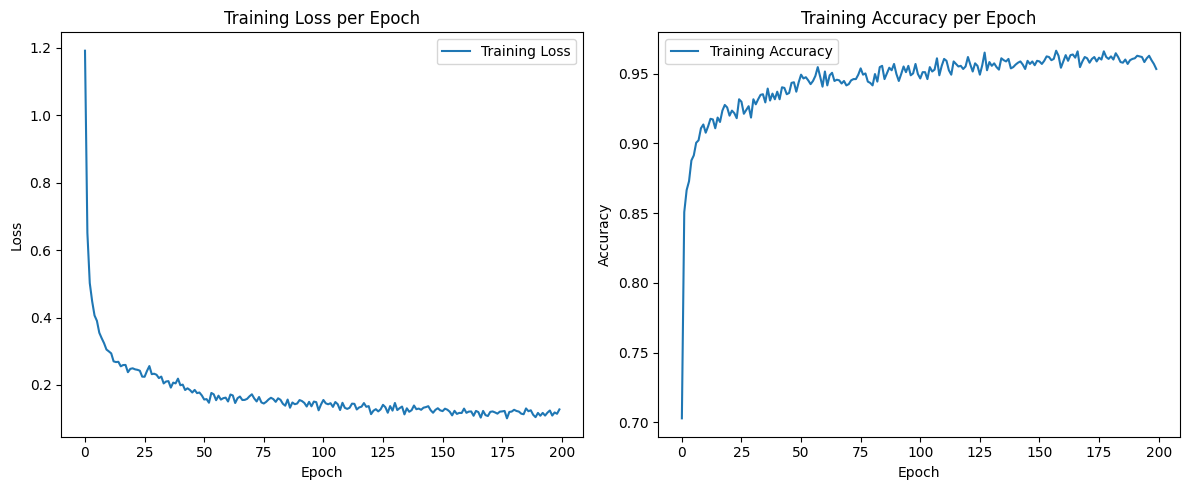

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [93]:
test_dataset = RNADataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
idx_to_ethnicity = {str(v): k for k, v in ethnicity_to_idx.items()}

In [98]:
test_loader

In [99]:
trained_model.eval()
test_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())

In [100]:
trained_model.eval()
softmax = Softmax(dim=1)

all_probs = []
all_true  = []

for batch in test_loader:
    # unpack first two items (inputs, labels), ignore rest
    inputs, labels, *rest = batch

    # 1) ensure at least 2D: if 1D, add batch dim
    if inputs.dim() == 1:
        inputs = inputs.unsqueeze(0)
    # 2) flatten anything >2D into [batch, -1]
    elif inputs.dim() > 2:
        inputs = inputs.view(inputs.size(0), -1)

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = trained_model(inputs)    # now always [B, C]
        probs  = softmax(logits)          # [B, C]

    all_probs.append(probs.cpu().numpy())
    all_true.append(labels.cpu().numpy())

# stack into big arrays
all_probs = np.vstack(all_probs)  # shape = [N_test, n_classes]
all_true  = np.hstack(all_true)   # shape = [N_test]

# map indices to your cleaned class names
class_names = [ idx_to_ethnicity[str(i)] for i in range(all_probs.shape[1]) ]

# build DataFrame
df = pd.DataFrame(all_probs, columns=class_names)
df['truth'] = [ idx_to_ethnicity[str(i)] for i in all_true ]

# write CSV for R
df.to_csv("./data/test_probs.csv", index=False)


In [101]:
target_names = list(ethnicity_to_idx.keys())

In [102]:
# Convert y_test and test_preds from numeric strings to ethnicity labels
y_test_labels = np.array([idx_to_ethnicity[str(x)] for x in y_test])
test_preds_labels = np.array([idx_to_ethnicity[str(x)] for x in test_preds])

# Check that the unique labels now match target_names
print("Unique labels in y_test_labels:", np.unique(y_test_labels))
print("Target names:", target_names)

# Compute overall accuracy using the mapped labels
final_accuracy = accuracy_score(y_test_labels, test_preds_labels)
print("Overall Accuracy:", final_accuracy)

# Generate classification report as a dictionary using the mapped labels
report_dict = classification_report(y_test_labels, test_preds_labels, target_names=target_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Only keep the rows for your label categories
report_df = report_df.loc[target_names].copy()

# Compute per-label accuracy manually
label_accuracies = {}
for label in target_names:
    mask = (y_test_labels == label)
    if np.sum(mask) > 0:
        label_accuracy = np.sum(y_test_labels[mask] == test_preds_labels[mask]) / np.sum(mask)
    else:
        label_accuracy = np.nan
    label_accuracies[label] = label_accuracy

# Map the per-label accuracy into the DataFrame
report_df['accuracy'] = report_df.index.map(lambda x: label_accuracies.get(x, np.nan))

# Reorder the columns as desired
report_df = report_df[['accuracy', 'precision', 'recall', 'f1-score']]

report_df['method'] = "MLP"

print(report_df)

Unique labels in y_test_labels: ['African' 'East Asian' 'European' 'Hispanic/Latin American' 'Japanese'
 'South Asian']
Target names: ['African', 'East Asian', 'European', 'Hispanic/Latin American', 'Japanese', 'South Asian']
Overall Accuracy: 0.9367088607594937
                         accuracy  precision    recall  f1-score method
African                  0.535714   0.882353  0.535714  0.666667    MLP
East Asian               0.934579   0.990099  0.934579  0.961538    MLP
European                 0.990854   0.920680  0.990854  0.954479    MLP
Hispanic/Latin American  0.583333   0.875000  0.583333  0.700000    MLP
Japanese                 1.000000   1.000000  1.000000  1.000000    MLP
South Asian              0.720000   0.857143  0.720000  0.782609    MLP


In [30]:
#final_accuracy = accuracy_score(y_test, test_preds)
#report_dict = classification_report(y_test, test_preds, target_names=target_names, output_dict=True)


In [31]:
#metrics = {
#    "Accuracy": final_accuracy,
#    "Precision": report_dict["macro avg"]["precision"],
#    "Recall": report_dict["macro avg"]["recall"],
#    "F1": report_dict["macro avg"]["f1-score"],
#    "Methods": "MLP"
#}

In [32]:
#metrics_df = pd.DataFrame([metrics])

In [33]:
#metrics_df1 = pd.melt(metrics_df, id_vars=["Methods"], var_name="Metrics", value_name="Score")

In [34]:
#metrics_df1

In [106]:
report_df.to_csv("./data/classifierMetrics.csv")

In [37]:
from torchviz import make_dot 

In [38]:
# Instantiate your MLP
input_dim = 100
hidden_dims = [128, 64, 32]
num_classes = 8
model = MLPClassifier(input_dim, hidden_dims, num_classes, dropout_prob=0.1)

# Create a dummy input for the forward pass
# For a batch size of 32 and an input dimension of 100:
dummy_input = torch.randn(32, input_dim)

# Pass the dummy input through the model
outputs = model(dummy_input)

# Use torchviz to create a graph of the model's computation
dot = make_dot(outputs, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [39]:
dot.render("mlp_torchviz", format="png")

'mlp_torchviz.png'

# predict on unlabelled data

In [107]:
query_adata = adata_query

In [108]:
if hasattr(query_adata.layers["counts_adjusted_ethnicity"], "toarray"):
    features_query = query_adata.layers["counts_adjusted_ethnicity"].toarray()
else:
    features_query = query_adata.layers["counts_adjusted_ethnicity"]

In [109]:
features_query = pca.transform(features_query)

In [110]:
features_query.shape

(2446, 20)

In [111]:
query_dataset = RNADataset(features_query)
query_loader = DataLoader(query_dataset, batch_size=32, shuffle=False)

In [112]:
trained_model.eval()
all_preds = []
with torch.no_grad():
    for inputs in query_loader:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

In [113]:
np.unique(all_preds, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 115,   92, 2130,   33,   15,   61]))

In [114]:
idx_to_ethnicity = {v: k for k, v in ethnicity_to_idx.items()}

In [115]:
ethnicity_predictions = [idx_to_ethnicity[p] for p in all_preds]

In [116]:
query_adata.obs["ethnicity_predictions"] = ethnicity_predictions

In [117]:
query_adata.obs

,sample_id,is_immune,do_analyse,donor_id,title,dataset_id,collection_id,age_days,sex,ethnicity_groups,tissue_groups,assay_groups,disease_groups,age_bin,TMM,multiplier,offset,ethnicity_predictions
0000c153da22cf963b807c0563aca6a6___1,0000c153da22cf963b807c0563aca6a6,1,True,homosapiens_None_2023_None_sikkemalisa_002_d10...,An integrated cell atlas of the human lung in ...,9f222629-9e39-47d0-b83f-e08d610c7479,6f6d381a-7701-4781-935c-db10d30de293,10585,female,African,respiratory system,10x Genomics 3,Normal,Young Adulthood,1.321811,7.743179,-2.046812,Hispanic/Latin American
00a08ee91e0bf44d1d35764ec9d8d909___1,00a08ee91e0bf44d1d35764ec9d8d909,1,True,Rep_C_1017,Type I interferon autoantibodies are associate...,01ad3cd7-3929-4654-84c0-6db05bd5fd59,7d7cabfd-1d1f-40af-96b7-26a0825a306d,23725,female,Hispanic/Latin American,blood,10x Genomics 5,Respiratory Conditions: General Respiratory Di...,Senior,1.451187,0.050635,2.983112,European
00c7d22d2be9210f46949ffacefca678___1,00c7d22d2be9210f46949ffacefca678,1,True,L11cov,A molecular single-cell lung atlas of lethal C...,d8da613f-e681-4c69-b463-e94f5e66847f,e4c9ed14-e560-4900-a3bf-b0f8d2ce6a10,25915,male,Hispanic/Latin American,respiratory system,10x Genomics 3,COVID-19 related,Senior,2.619561,3.217668,-1.168657,East Asian
017ee380d0ed3bc7655dedf629ba52d3___1,017ee380d0ed3bc7655dedf629ba52d3,1,True,D4,All — Cells of the adult human heart,d4e69e01-3ba2-4d6b-a15d-e7048f78f22e,b52eb423-5d0d-4645-b217-e1c6d38b2e72,27192,female,European,cardiovascular system,10x Genomics 3,Normal,Senior,6.999609,420.733105,-6.041999,European
031f7d087719a36b939649d50db6ae18___1,031f7d087719a36b939649d50db6ae18,1,True,HCA_29_ref,Single cell RNA-seq data from normal adult kid...,0b4a15a7-4e9e-4555-9733-2423e5c66469,a98b828a-622a-483a-80e0-15703678befd,18250,female,European,renal system,10x Genomics 3,Normal,Middle Age,1.645557,68.209753,-4.222588,European
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff2117e77461f6d7f2b4bdb98351b125___1,ff2117e77461f6d7f2b4bdb98351b125,1,True,Wilms1,Mature kidney dataset: full,9ea768a2-87ab-46b6-a73d-c4e915f25af3,120e86b4-1195-48c5-845b-b98054105eec,1460,male,Other/Unknown,renal system,10x Genomics 3,Normal,Childhood,1.164732,94.183002,-4.545240,European
ff3f3215060b48696327c3dfe31b3a82___1,ff3f3215060b48696327c3dfe31b3a82,1,True,Control_Participant10,Nasopharynx,13b61a7d-5605-4948-ba48-02c588960143,35d0b748-3eed-43a5-a1c4-1dade5ec5ca0,23542,female,Other/Unknown,"nasal, oral, and pharyngeal regions",Microwell Technologies,Normal,Senior,4.205549,20.066918,-2.999073,European
ffa16ac41fc1b7e236b0baa625ebf241___1,ffa16ac41fc1b7e236b0baa625ebf241,1,True,PP17,Airway,edc8d3fe-153c-4e3d-8be0-2108d30f8d70,03f821b4-87be-4ff4-b65a-b5fc00061da7,5475,male,Other/Unknown,"nasal, oral, and pharyngeal regions",10x Genomics 5,COVID-19 related,Adolescence,2.241030,40.103179,-3.691456,European
ffb833f3042a1449d574497493823315___1,ffb833f3042a1449d574497493823315,1,True,S00076,COMBAT project: single cell gene expression da...,ebc2e1ff-c8f9-466a-acf4-9d291afaf8b3,8f126edf-5405-4731-8374-b5ce11f53e82,1095,female,Other/Unknown,blood,10x Genomics 5,COVID-19 related,Infancy,1.283265,2.731541,-1.004866,European


In [118]:
query_adata.write("./data/adata_unlabelled_with_predictions.h5ad")

In [63]:
#query_adata.to_csv("./data/adata_unlabelled_with_predictions.csv", index=False)